In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
np.random.seed(42)

## Load Histograms and Data Statistics

In [3]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [4]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000,-3.043901,-1.0,9.212087,110.625000,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.138240,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625000,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [5]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [6]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [7]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [8]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


# Reproducing Dataframe from Information

In [9]:
'''
Function that converts the 4-dimensional histogram into a dataframe according
to the information given by the summarizing statistics
'''
def histogram_to_dataframe(hist, state, statistics, sample_size=1):
    
    #Get all statistics for all features from summary
    energy_min = statistics['energy_norm_log_min']
    energy_max = statistics['energy_norm_log_max']
    energy_range = energy_max - energy_min
    energy_bins = np.linspace(energy_min, energy_max, num=20)
    energy_bin_size = energy_range/19
    
    temp_min = statistics['temperature_diff_min']
    temp_max = statistics['temperature_diff_max']
    temp_range = temp_max - temp_min
    temp_bins = np.linspace(temp_min, temp_max, num=20)
    temp_bin_size = temp_range/19
    
    rms_min = statistics['rms_norm_log_min']
    rms_max = statistics['rms_norm_log_max']
    rms_range = rms_max - rms_min
    rms_bins = np.linspace(rms_min, rms_max, num=20)
    rms_bin_size = rms_range/19
    
    details_min = statistics['details_ratedhead_min']
    #correcting manual error
    details_min = 0
    details_max = statistics['details_ratedhead_max']
    details_range = details_max - details_min
    details_bins = np.linspace(details_min, details_max, num=20)
    details_bin_size = details_range/19
    
    #Iterate through every bin and reproduce observations based on the bin features
    vstacked = np.empty([0, 4])
    for i,_ in enumerate(tqdm(hist)):
        for j in range(len(hist[i])):
            for k in range(len(hist[i][j])):
                for l in range(len(hist[i][j][k])):
                    amount = math.ceil(hist[i][j][k][l]*sample_size)
                    if amount != 0:
                        d = np.random.uniform(low=details_bins[i], high=details_bins[i]+details_bin_size, size=(amount,))
                        r = np.random.uniform(low=rms_bins[j], high=rms_bins[j]+rms_bin_size, size=(amount,))
                        t = np.random.uniform(low=temp_bins[k], high=temp_bins[k]+temp_bin_size, size=(amount,))
                        e = np.random.uniform(low=energy_bins[l], high=energy_bins[l]+energy_bin_size, size=(amount,))
                        dstacked = np.dstack((e,t,r,d))[0]
                        vstacked = np.vstack((vstacked,dstacked))
    #Generating dataframe                    
    rep_df = pd.DataFrame(data=vstacked, columns=['energy_norm_log','temperature_diff','rms_norm_log','details_ratedhead'])
    #Adding target class
    rep_df['state'] = state

    return rep_df

### Generating ON Dataframe with target variable 'state' = 1

In [10]:
rep_df_on = histogram_to_dataframe(hist=hist_on,
                                   state=1, 
                                   statistics=summarizing_statistics.loc['on'],
                                   sample_size=1)

100%|██████████| 20/20 [10:50<00:00, 32.51s/it]  


In [11]:
rep_df_on.tail()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
9639502,5.501651,27.471074,2.769536,2285.678793,1
9639503,6.659067,26.489316,2.671852,2357.845701,1
9639504,6.599858,25.797360,2.751762,2296.876701,1
9639505,7.533769,27.685310,2.489246,2360.028877,1
9639506,6.948340,27.085487,2.645789,2330.863101,1


### Generating OFF Dataframe with target variable 'state' = 0

In [13]:
rep_df_off = histogram_to_dataframe(hist=hist_off,
                                   state=0, 
                                   statistics=summarizing_statistics.loc['off'],
                                   sample_size=1)

100%|██████████| 20/20 [10:33<00:00, 31.69s/it]


In [14]:
rep_df_off.tail()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
16741530,0.120342,14.757239,0.283075,2368.855864,0
16741531,0.684643,14.828647,0.228110,2290.105121,0
16741532,0.540681,8.416417,0.455902,2366.642130,0
16741533,0.142217,19.678292,0.221567,2361.793382,0
16741534,3.067294,4.833927,1.085451,2362.007917,0


### Merging new Dataframes and generating statistics

In [15]:
rep_df_all = pd.concat([rep_df_on, rep_df_off], ignore_index=True)
rep_df_all.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [16]:
def generate_statistics(df, state=None):
    if state == 0:
        label = 'off_replica'
    elif state == 1:
        label = 'on_replica'
    else:
        label = 'all_replica'

    statistics = pd.DataFrame([[label,
                    len(df),
                    df['energy_norm_log'].mean(),
                    df['temperature_diff'].mean(),
                    df['rms_norm_log'].mean(),
                    df['details_ratedhead'].mean(),
                    df['energy_norm_log'].min(),
                    df['temperature_diff'].min(),
                    df['rms_norm_log'].min(),
                    df['details_ratedhead'].min(),
                    df['energy_norm_log'].max(),
                    df['temperature_diff'].max(),
                    df['rms_norm_log'].max(),
                    df['details_ratedhead'].max(),
                    df.cov().values]],
                    columns=summarizing_statistics.columns.insert(0,'label')).set_index('label')
    return statistics

In [17]:
replica_statistics_on = generate_statistics(rep_df_on, state=1)

In [18]:
replica_statistics_off = generate_statistics(rep_df_off, state=0)

In [19]:
replica_statistics_all = generate_statistics(rep_df_all, state=None)

In [20]:
replica_summarizing_statistics = pd.concat([summarizing_statistics.iloc[[0]], replica_statistics_on, summarizing_statistics.iloc[[1]], replica_statistics_off, summarizing_statistics.iloc[[2]], replica_statistics_all])
replica_summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,"[[4.054988675775044, 1.6181932043448362, 1.438..."
on_replica,9639507,2.262454,11.145556,0.925975,118.743587,-5.843427,-23.977141,-3.021036,0.000006,10.007755,117.621411,6.767623,2402.992395,"[[4.600377879653974, 1.66251134457744, 1.59768..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875000,-4.430309,-1.000000,7.588837,109.140903,4.138240,2403.000000,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
off_replica,16741535,-2.791476,4.517446,-1.396657,107.331233,-9.894227,-37.217121,-4.272182,0.000004,8.534652,106.621120,4.482172,2402.991829,"[[1.7771239801612835, 0.09465789748463314, 0.8..."
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875000,-4.430309,-1.000000,9.212087,110.625000,6.308744,2403.000000,"[[8.466562429846425, 10.45687699516861, 3.7031..."
all_replica,26381042,-0.944794,6.939326,-0.547978,111.501253,-9.894227,-37.217121,-4.272182,0.000004,10.007755,117.621411,6.767623,2402.992395,"[[8.731495534351946, 8.435113661993915, 3.8401..."


## Insight into Dataframe

### Energy Distribution

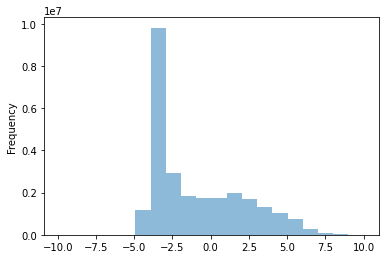

In [21]:
ax = rep_df_all['energy_norm_log'].plot.hist(bins=20, alpha=0.5)

### Energy Distribution

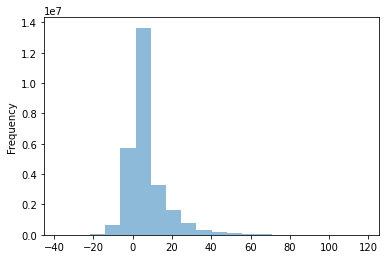

In [22]:
ax = rep_df_all['temperature_diff'].plot.hist(bins=20, alpha=0.5)

### Energy Distribution

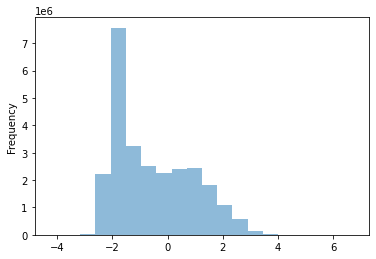

In [23]:
ax = rep_df_all['rms_norm_log'].plot.hist(bins=20, alpha=0.5)

### Energy Distribution

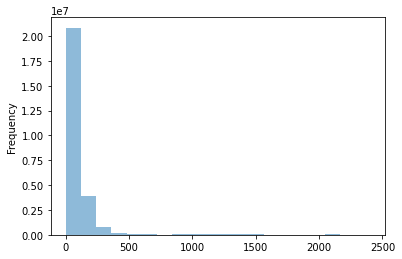

In [24]:
ax = rep_df_all['details_ratedhead'].plot.hist(bins=20, alpha=0.5)

# Save Dataframe and Statistics

In [25]:
replica_summarizing_statistics.to_csv('./data/replica_summarizing_statistics.csv', index=True)

In [26]:
rep_df_all.to_csv('./data/replica_pump_data.csv', index=False)

# Old Code

## Splitting histogram into single features

In [27]:
energy_hist = []
temp_hist = []
rms_hist = []
details_hist = []
for i in range(len(hist_on)):
    energy_total = 0
    temp_total = 0
    rms_total = 0
    details_total = 0
    for j in range(len(hist_on[i])):
        for k in range(len(hist_on[i][j])):
            for l in range(len(hist_on[i][j][k])):
                energy_total += hist_on[i][j][k][l]
                temp_total += hist_on[j][i][k][l]
                rms_total += hist_on[j][k][i][l]
                details_total += hist_on[j][k][l][i]
    energy_hist.append(energy_total)
    temp_hist.append(temp_total)
    rms_hist.append(rms_total)
    details_hist.append(details_total)